## 4. Evaluation Metrics for Classification 

### 4.1 Evaluation metrics: session overview

- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn

- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

- Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [5]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [6]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [7]:
model = LogisticRegression(max_iter=100)
model.fit(X_train, y_train)

/usr/local/anaconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

### Accuracy

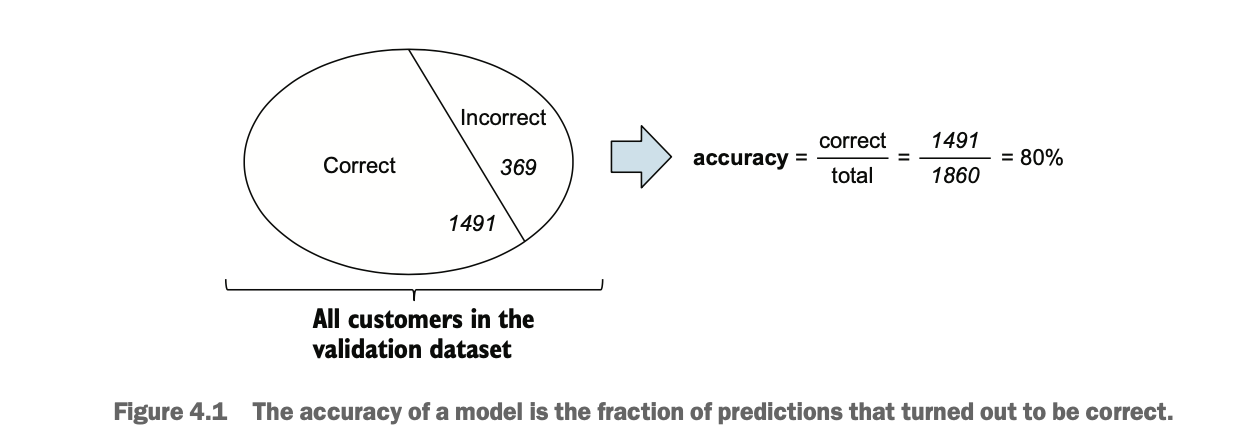

In [9]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

0.8034066713981547

In [10]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

### 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds (currently set at 0.5)
- Check the accuracy of dummy baselines

In [11]:
total_observations = len(y_val)

In [12]:
correct_pred = (y_val == churn).sum()

In [13]:
correct_pred / total_observations

0.8034066713981547

In [14]:
#evaluate our predictions for 21 thresholds
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    churn = (y_pred >= t)
    score = (y_val == churn).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.591
0.15 0.667
0.20 0.710
0.25 0.738
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [15]:
#evaluate our predictions for 21 thresholds
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.591
0.15 0.667
0.20 0.710
0.25 0.738
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [19]:
from collections import Counter
Counter(y_val)

Counter({0: 1023, 1: 386})

In [24]:
#Customers who will not "churn" and customer who will "churn"
1-y_val.mean(), y_val.mean()

(0.7260468417317246, 0.2739531582682754)

The best accuracy is achieved when cutting the predictions at the 0.5 threshold: if a prediction is higher than 0.5, we predict “churn,” and otherwise, we predict “no churn.”

Why bother when our model is accurate 80% of the time when our y_pred is greater or equal to the threshold of 0.5, and we obtain an accuracy of 72% when our y_pred is == to the threshold of 1 (dummy model).

A threshold of 1 is telling us that no one will churn, will always output False and will have an decent accuracy of 72%

WHAT HAPPENS HERE IS THAT OUR MODEL is imbalanced, we have more non-churning (1,023)
users than churning ones (386). We have 3 times more non-churning than churning.

When we are trying to predict a class and turns out to be the majority class and we have class imbalance, the dummy models will always have a good accuracy. Accuracy is a misleading score for cases with class imbalance.

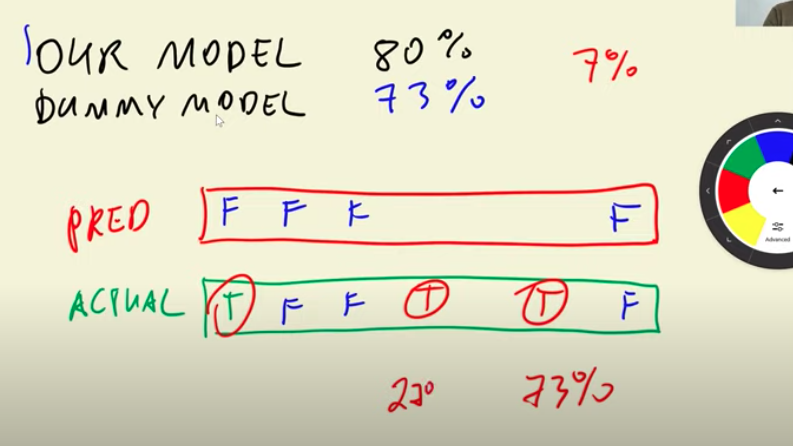

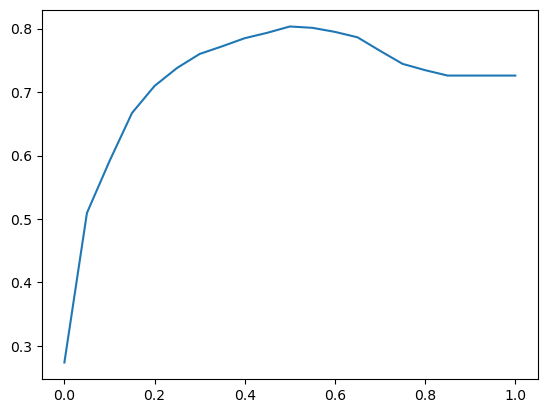

In [16]:
plt.plot(thresholds, scores)
plt.show()

### 4.3 Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

Even though accuracy is easy to understand, it’s not always the best metric. In fact, it sometimes can be misleading. We’ve already seen this occur: the accuracy of our model is 80%, and although that seems like a good number, it’s just 6% better than the accuracy of a dummy model that always outputs the same prediction of “no churn.”
This situation typically happens when we have a class imbalance (more instances of one class than another). We know that this is definitely the case for our problem: 74% of customers did not churn, and only 26% did churn.

Applying the <u>confusion table</u> we evaluate the quality of our model, that is not affected by the class imbalance.

For a binary classification model we can have only two possible predictions: True and False. In our case, we can predict that a customer is either going to churn (True) or not (False).

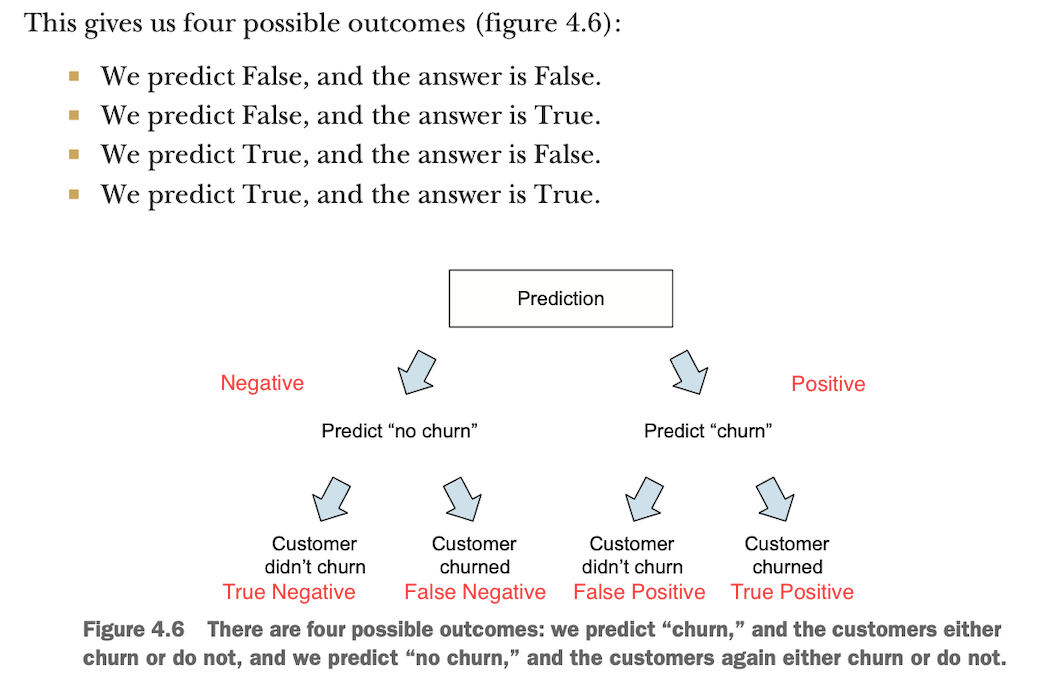

- True negative (TN): we predict False (“no churn”), and the actual label is also False (“no churn”).
- True positive (TP): we predict True (“churn”), and the actual label is True (“churn”).
- False negative (FN): we predict False (“no churn”), but it’s actually True (the customer churned).
- False positive (FP): we predict True (“churn”), but it’s actually False (the cus- tomer stayed with us).

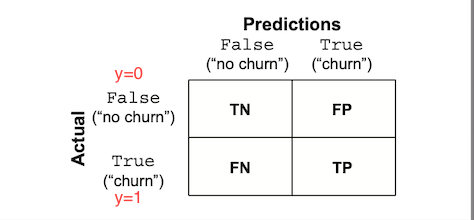

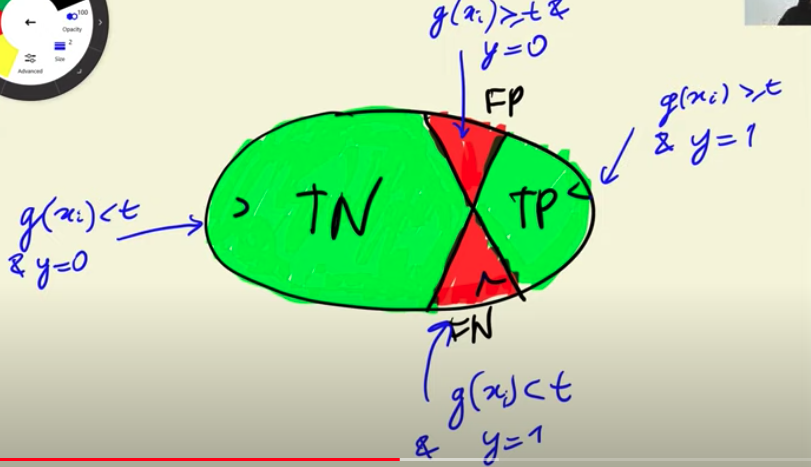




In [25]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

predict_positive = (y_pred >= 0.5)
predict_negative = (y_pred < 0.5)

In [31]:
tp = (actual_positive & predict_positive).sum()
tn = (actual_negative & predict_negative).sum()

fn = (actual_positive & predict_negative).sum()
fp = (actual_negative & predict_positive).sum()

tp, tn, fn, fp

(210, 922, 176, 101)

In [33]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

In [37]:
confusion_matrix_norm = (confusion_matrix/confusion_matrix.sum()).round(2)
confusion_matrix_norm

array([[0.65, 0.07],
       [0.12, 0.15]])

In [90]:
confusion_matrix_norm[1:,0], confusion_matrix_norm[:1,1]

(array([0.12]), array([0.07]))

In [98]:
fp_fn = confusion_matrix_norm[:1,1] + confusion_matrix_norm[1:,0]
fp_fn[0]

0.19

In [96]:
confusion_matrix_norm[1:,1], confusion_matrix_norm[:1,0]

(array([0.15]), array([0.65]))

In [101]:
#by adding tp and tn, we have 80% of accuracy, the same as the previous accuracy metric
tn_tp = confusion_matrix_norm[1:,1] + confusion_matrix_norm[:1,0]
tn_tp[0]

0.8